In [1]:
import numpy as np
from scipy.optimize import linprog as lp
from scipy.stats import norm
from matplotlib import pyplot as plt

## LP Solver
The scipy.optimize LP solver takes the coefficients of the objective, $O$, a matrix as the coefficients for the inequality ($\leq$) constraints, $A_{ineq}$, a vector, $b_{ineq}$ as the right hand side for the constraints, a second matrix, $A_{eq}$, for the coefficients of the equality constraints, and the vector $b_{eq}$ for the right hand side, and a list of intervals, $b$, for the bounds of the variables. It then solves the problem:

$$min_x \quad O \cdot x$$
constrained to
\begin{align*}
A_{ineq} \cdot x & \leq b_{ineq} \\
A_{eq} \cdot x & = b_{eq} \\
x_i
\end{align*}

In [3]:
class LP():
    def __init__(self,o,ai,bi,ae,be,b):
        self.o = o
        self.ai = ai
        self.bi = bi
        self.ae = ae
        self.be = be
        self.b = b
        self.opt = 0
    
    def optimise(self):
        bnds = []
        for i in self.b:
            if i==0:
                bnds.append((-np.inf,np.inf))
            elif i==1:
                bnds.append((-np.inf,0))
            else:
                bnds.append((0,np.inf))
        if len(self.ae) > 0:
            opt = lp(c=self.o, A_ub=self.ai, b_ub=self.bi,A_eq=self.ae, b_eq=self.be, bounds=bnds,method="highs")
        else:
            opt = lp(c=self.o, A_ub=self.ai, b_ub=self.bi, bounds=bnds,method="highs")
        self.opt = opt
        return opt

    def dual(self):
        if len(self.ae) > 0:
            obj = -1*np.concatenate([self.bi,self.be])
            lhs = np.concatenate([self.ai,self.ae])
            bnds = [1]*(len(self.bi))+[0]*(len(self.be))
        else:
            obj = -1*self.bi
            lhs = self.ai
            bnds = [1]*(len(self.bi))
        
        lhst = np.transpose(lhs)
        rhs = self.o
        li = []
        ri = []
        le = []
        re = []
        
        for i in range(len(self.b)):
            if self.b[i] == 1:
                li.append(-1*lhst[i])
                ri.append(-1*rhs[i])
            elif self.b[i] == 2:
                li.append(lhst[i])
                ri.append(rhs[i])
            else:
                le.append(lhst[i])
                re.append(rhs[i])
        dualp = LP(obj, np.array(li), np.array(ri), np.array(le), np.array(re), bnds)
        return dualp

class Option():
    def __init__(self, k, putcall):
        self.k = k
        self.pc = putcall
        self.dp = 1/(s*t**0.5)*(np.log(S0/k)+(r+0.5*s**2)*t)
        self.dm = 1/(s*t**0.5)*(np.log(S0/k)+(r-0.5*s**2)*t)
        if self.pc == 'call':
            self.pk = S0*norm.cdf(self.dp)-k*np.exp(-r*t)*norm.cdf(self.dm)
            self.dpk = -S0*np.exp(-self.dp**2/2)/(s*np.sqrt(t*2*np.pi)*k) - np.exp(-r*t)*norm.cdf(self.dm) + np.exp(-self.dm**2/2 - r*t)/(s*np.sqrt(t*2*np.pi))
        else:
            self.pk = -S0*norm.cdf(-self.dp)+k*np.exp(-r*t)*norm.cdf(-self.dm)
            self.dpk = np.exp(-r*t)-S0*np.exp(-self.dp**2/2)/(s*np.sqrt(t*2*np.pi)*k) - np.exp(-r*t)*norm.cdf(self.dm) + np.exp(-self.dm**2/2 - r*t)/(s*np.sqrt(t*2*np.pi))
        
    def value(self, stock):
        if self.pc == 'call':
            return np.maximum(stock-self.k, 0)
        else:
            return np.maximum(self.k-stock, 0)

    def __sub__(self, other):
        return Option(self.k-other, self.pc)
    
    def __add__(self, other):
        return Option(self.k+other, self.pc)
    
    def __str__(self):
        return str(self.k)
    
    def __repr__(self):
        return str(self.k)

In [15]:
# Parameter Values

S0 = 1              # initial stock price
normalized_S0 = 1   # normalized initial stock price
mu = 0.1            # drift
s = 0.2             # volatility for pricing
sigma = 0.15        # volatility for simulation
r = 0.05            # riskfree rate
t = 1               # time to maturity(in year)
T = t
alpha = 0.025       # significance level
beta = 1 - alpha
R = 0.001               # minimum expected gain
c = 0.0035          # hedging budget
q = 500            # number of paths

In [5]:
def bsmcall(k):
    dp = 1/(s*t**0.5)*(np.log(1/k)+(r+0.5*s**2)*t)
    dm = 1/(s*t**0.5)*(np.log(1/k)+(r-0.5*s**2)*t)
    pk = norm.cdf(dp)-k*np.exp(-r*t)*norm.cdf(dm)
    dpk = -np.exp(-dp**2/2)/(s*np.sqrt(t*2*np.pi)*k) - np.exp(-r*t)*norm.cdf(dm) + np.exp(-dm**2/2 - r*t)/(s*np.sqrt(t*2*np.pi))
    return pk, dpk

def bsmput(k):
    dp = 1/(s*t**0.5)*(np.log(1/k)+(r+0.5*s**2)*t)
    dm = 1/(s*t**0.5)*(np.log(1/k)+(r-0.5*s**2)*t)
    pk = -norm.cdf(-dp)+k*np.exp(-r*t)*norm.cdf(-dm)
    dpk = np.exp(-r*t)-np.exp(-dp**2/2)/(s*np.sqrt(t*2*np.pi)*k) - np.exp(-r*t)*norm.cdf(dm) + np.exp(-dm**2/2 - r*t)/(s*np.sqrt(t*2*np.pi))
    return pk, dpk

In [6]:
def geomsimput(q,k,si):
    n = len(k)
    der = np.zeros((n,2+q,1+n+q))
    pk = []
    dpk = []
    for i in range(n):
        pki, dpki = (k[i].pk, k[i].dpk)
        pk.append(pki)
        dpk.append(dpki)
    pk = np.array(pk)
    dpk = np.array(dpk)
    returns = np.zeros((n+1,q))
    returns[0] = S0*np.exp((-0.5*sigma**2+mu)*t+sigma*(t**0.5)*si)
    count = []
    for i in range(n):
        returns[i+1] = k[i].value(returns[0])
        der[i,1:-1,i+1] = (returns[i+1]==0).astype(int)-1+np.exp(r*t)*dpk[i]
        count.append(-1*sum(der[i,:,1]))
    count = np.array(count)
    der[:,0,1] = count/q + np.exp(r*t)*dpk[i]
    der[:,-1,1] = dpk
    return (returns, der, pk, q, k,n)

In [7]:
def sortbystock(returns):
    a = [list(row) for row in np.transpose(returns)]
    b = sorted(a, key = lambda x: x[0])
    stock = [row[0] for row in b]
    x = [row[1] for row in b]
    y = [row[2] for row in b]
    return stock, x, y

In [16]:
def cvarlp(model):
    returns, der, pk, q, k, n = model
    
    m = []
    for i in range(len(returns)):
        m.append(-sum(returns[i])/q)         # negative of mean value at time T.
#     print(m)
    # variables are alpha, n x's and q u's. x is the number of instruments held.
    obj = [1]+[0]*n+[1/(q*(1-beta))]*q
    lhs_ineq = [[0]+m[1:]+[0]*q]
    for i in range(n):
        lhs_ineq[0][1+i] += np.exp(r*t)*pk[i]
    rhs_ineq = [-R-m[0]-(S0)*np.exp(r*t)]
    for i in range(q):
        const = [-1] + [-returns[j+1][i]+np.exp(r*t)*pk[j] for j in range(n)]+[0]*q
        const[1+n+i] = -1
        lhs_ineq.append(const)
        rhs_ineq.append(returns[0][i]-S0*np.exp(r*t))

    lhs_ineq += [[0]+list(pk)+[0]*q]
    rhs_ineq += [c]
    
    lhs_eq = []
    rhs_eq = []

    bnd = [0]+[0]*n+[2]*q    # 0 is with selling, 2 is without

    primal = LP(np.array(obj), np.array(lhs_ineq), np.array(rhs_ineq), np.array(lhs_eq), np.array(rhs_eq), np.array(bnd))
    return primal, m

def loss(model):
    returns, der, pk, q, k, n = model
    primal, m = cvarlp(model)
    opt = primal.optimise()
    dual = primal.dual()
    optd = dual.optimise()
    xprime = opt.x
    xdual = optd.x
    
    nabla = -np.matmul(xdual.reshape(-1,1), xprime.reshape(1,-1))

    grad = []
    for i in range(n):
        grad.append(np.sum(np.sum(nabla*der[i])))
    grad = np.array(grad)
#     print("1 down")
    return grad, opt, -sum([opt.x[1+i]*m[1+i] for i in range(n)])-m[0]-(S0+sum([opt.x[1+i]*k[i].pk for i in range(n)]))*np.exp(r*t)

def bruteloss(q,k,si):
    der = []
    delta = 0.01
    primal, m = cvarlp(geomsimput(q,k,si))
    opt = primal.optimise()
    x0 = opt.fun
    for i in range(len(k)):
        uv = np.zeros((len(k),))
        uv[i] = delta
        kd = k + uv
        pd, m = cvarlp(geomsimput(q,kd,si))
        der.append((pd.optimise().fun-x0)/delta)
    return der

In [18]:
si = norm.rvs(loc=0, scale=1, size=q)

In [21]:
# The initial parameters of the algorithm
k = np.array([Option(1, 'put'), Option(1, 'call'),Option(0.9, 'put'), Option(0.9, 'call'),Option(1.1, 'put'), Option(1.1, 'call')])  # , Option(1, 'call'),Option(0.9, 'put'), Option(0.9, 'call'),Option(1.1, 'put'), Option(1.1, 'call'),Option(0.8, 'put'), Option(0.8, 'call'),Option(1.2, 'put'), Option(1.2, 'call'),Option(0.7, 'put'), Option(0.7, 'call')
n = len(k)
lr=0.001            # learning rate
beta1=0.9              # exponential decay rate for the 1st order moment estimate
beta2=0.999            # exponential decay rate for the 2nd order moment estimate
error=1e-8             # preventing the division by zero error
R=0.053
m=np.zeros((n))                       # initial 1st moment vector
v=np.zeros((n))                       # initial 2nd moment vector
maxiter = 1000             # maximum no of iterations
reltol = 1e-4             # absolute difference between two successive iterates
for i in range(maxiter):
    model = geomsimput(q, k, si)
    grad_ab, opt, ret = loss(model)  # bruteloss(q, k, si)
    if (i+1)%(maxiter//10) == 0:
        print("Epoch", i+1, "of", maxiter, "\nCVaR:", opt.fun, "   VaR:", opt.x[0], "\nStrike =", k, "\nGradient:", grad_ab, "    Average Return:", ret)
        print("Portfolio: ", opt.x[1:n+1], "\n")
#         print(bruteloss(q,k,si))
    m = beta1*m+(1-beta1)*grad_ab
    v = beta2*v+(1-beta2)*(grad_ab*grad_ab)
    bcm = m/(1-(beta1**(i+1)))
    bcv = v/(1-(beta2**(i+1)))
    k -= ((lr*bcm)/(np.sqrt(bcv)+error))
    for strike in k:
        if strike.pc == 'call' and strike.k > 1.6:
            strike.k = 1.6
        if strike.pc == 'put' and strike.k < 0.7:
            strike.k = 0.7
    
        


Epoch 100 of 1000 
CVaR: 0.1508004361366802    VaR: 0.14832757550814585 
Strike = [1.1123310395391932 1.1104452919723813 1.0137703489924386
 1.009993072900605 1.2133677680980361 1.1709564435975008] 
Gradient: [-3.7931264  -5.48282828 -2.25275668 -2.25976137 -2.01301605  1.16179364]     Average Return: 0.052999999999999714
Portfolio:  [ 3.03597318e+00  7.25229082e+00  2.54827040e-12 -3.15223111e-12
 -2.03597318e+00 -9.72306907e+00] 

Epoch 200 of 1000 
CVaR: 0.1504686529165289    VaR: 0.1504686529165289 
Strike = [1.1153204882324066 1.1358735268142908 1.024115014355433 1.016429661975524
 1.2152375214429405 1.1593910287693343] 
Gradient: [  1.6714479   26.25038601   0.06348592  -4.19722616   1.03343762
 -18.48481877]     Average Return: 0.053000000000000824
Portfolio:  [-1.31168796e+00 -6.21692000e+01  2.31168796e+00  8.44392561e+00
  2.52075012e-13  5.27252744e+01] 

Epoch 300 of 1000 
CVaR: 0.15109924043495185    VaR: 0.14858551618091406 
Strike = [1.1170745005077702 1.1344784182813938

In [22]:
k[0].pk*opt.x[1]+k[1].pk*opt.x[2]

-10.545413631902598

In [24]:
plt.clf()
plt.plot([i/100 for i in range(200)],[Option(i/100, 'put').pk for i in range(200)], label='Put')
plt.plot([i/100 for i in range(200)],[Option(i/100, 'call').pk for i in range(200)], label='Call')
# plt.hlines(cvar, xmin = beta, xmax = 1, color='orange')
# plt.xticks(ticks = [beta, 1], labels = ['β', 1.0])
# plt.yticks(ticks = [b[int(q*beta)], cvar], labels = ['VaR', 'CVaR'])
plt.legend()
plt.ylabel("Price")
plt.xlabel("Strike")
plt.show()

ZeroDivisionError: float division by zero

<Figure size 640x480 with 0 Axes>

In [31]:
sisort = np.array(sorted(si))
stocks =  S0*np.exp((-0.5*sigma**2+mu)*t+sigma*(t**0.5)*sisort)
money = stocks + sum([k[i].value(stocks)*opt.x[i+1] for i in range(len(k))])
cost = S0 + sum([k[i].pk*opt.x[i+1] for i in range(len(k))])
badness = cost*np.exp(r*t) - money
badness2 = S0*np.exp(r*t) - stocks
optpayoff = sum([k[i].value(stocks)*opt.x[i+1] for i in range(len(k))])
print(badness)

[ 1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992145e-01  1.43992145e-01  1.43992145e-01
  1.43992145e-01  1.43992

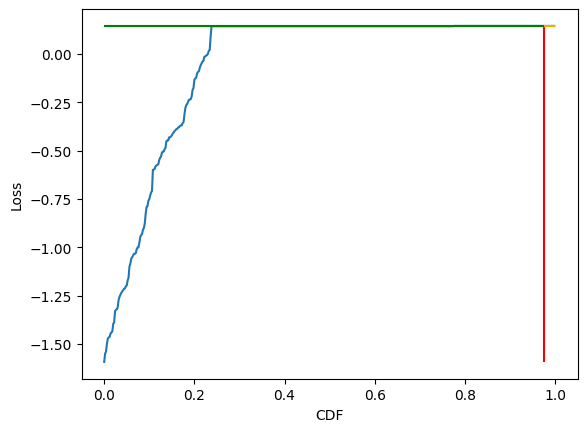

In [36]:
b = sorted(badness)
tail = b[int(q*beta):]
cvar = sum(tail)/len(tail)
plt.clf()
plt.plot([i/len(si) for i in range(len(si))],b)
# plt.plot([i/len(si) for i in range(len(si))],badness2)
# plt.plot(stocks,optpayoff)
plt.ylabel("Loss")
plt.xlabel("CDF")
plt.vlines(beta, ymin = b[0], ymax = b[int(q*beta)], color='red')
plt.hlines(b[int(q*beta)], xmin = 0, xmax = beta, color='green')
plt.hlines(cvar, xmin = beta, xmax = 1, color='orange')
# plt.xticks(ticks = [beta, 0.2,0.4,0.6,0.8,1.0], labels = ['β', 0.2,0.4,0.6,0.8,1.0])
# plt.yticks(ticks = [b[int(q*beta)], cvar, -0.8,-0.6,-0.4,-0.2,0,0.4], labels=['VaR', 'CVaR', -0.8,-0.6,-0.4,-0.2,0,0.4])
plt.show()

In [27]:
np.exp(mu*t)

1.1051709180756477